## It's time for `classification` problem

We spend time on solving regression problem!<br>
For classification problem we need to make 2 things!

- Softmax
- Cross Entropy Loss

**But before let's make `slice` function** to manage the tensor's more easily!

## `Slice`

In [ ]:
class GetItem(Function):
    def __init__(self, slices):
        self.slices = slices
        
    def forward(self, x):
        y = x[self.slices]
        return y
    
    def backward(self, gy):
        x, = self.inputs
        gx = GetItemGrad(self.slices, x.shape)(gy)
        return gx
    
def get_item(x, slices):
    return GetItem(slices)(x)

There is no funciton for `Slice` so let's make another.

In [ ]:
class GetItemGrad(Funtion):
    def __init__(self, slices, in_shape):
        self.slices = slices
        self.in_shape = in_shape
        
    def forward(self, gy):
        gx = np.zeros(self.in_shape)
        np.add.at(gx, self.slices, gy)
        return gx
    
    def backward(self, ggx):
        return get_item(ggx, self.slices)

- How `np.add.at` works?

In [12]:
import numpy as np

a = np.zeros((2, 3))
a

array([[0., 0., 0.],
       [0., 0., 0.]])

In [13]:
b = np.ones((3,))
b

array([1., 1., 1.])

In [7]:
slices = 1
np.add.at(a, slices, b)
a

array([[0., 0., 0.],
       [1., 1., 1.]])

Same work :)!

In [14]:
a[slices] = b
a

array([[0., 0., 0.],
       [1., 1., 1.]])

### Test!

In [18]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([[1, 2, 3],
                       [4, 5, 6]]))
y = F.get_item(x, 1)
print(y)

Variable([4 5 6])


In [19]:
y.backward()
print(x.grad)

Variable([[0. 0. 0.]
          [1. 1. 1.]])


In [16]:
print(y.grad)

None


In [20]:
x = Variable(np.array([[1, 2, 3],
                       [4, 5, 6]]))
indices = np.array([0, 0, 1])
y = F.get_item(x, indices)
print(y)

Variable([[1 2 3]
          [1 2 3]
          [4 5 6]])


In [21]:
y.backward()
print(x.grad)

Variable([[2. 2. 2.]
          [1. 1. 1.]])


### How does `slices` handle `1:3`?

In [23]:
class IndiceCheck:
    def __getitem__(self, slices):
        print(slices)

In [24]:
ic = IndiceCheck()

In [25]:
ic[1]

1


In [26]:
ic[1:3]

slice(1, 3, None)


In [25]:
ic[1]

1


In [29]:
F.get_item(x, slice(1, 3, None))

Variable([[4 5 6]])

In [27]:
slice(1, 3)

slice(1, 3, None)

## `Slice` for Variable `__getitem__`

```python
Variable.__getitem__ = F.get_item
```

In [21]:
y.backward()
print(x.grad)

Variable([[2. 2. 2.]
          [1. 1. 1.]])


In [1]:
import numpy as np
from dezero import Variable

x = Variable(np.array([[1, 2, 3],
                       [4, 5, 6]]))
y = x[1]
print(y)

Variable([4 5 6])


In [2]:
y.backward()
print(x.grad)

Variable([[0. 0. 0.]
          [1. 1. 1.]])


In [3]:
x = Variable(np.array([[1, 2, 3],
                       [4, 5, 6]]))
y = x[:,2]
print(y)

Variable([3 6])


In [4]:
y.backward()
print(x.grad)

Variable([[0. 0. 1.]
          [0. 0. 1.]])


## `Softmax` Function

## $p_{k} = \frac{exp(y_{k})}{\sum^{n}_{i=1} exp(y_{i})}$

In [5]:
from dezero.models import MLP

model = MLP((10, 3))

In [6]:
x = np.array([[0.2, -0.4]])
y = model(x)
print(y)

Variable([[0.44170413 0.46544621 0.30717265]])


`yield from` used to make generator inside generator

In [7]:
from dezero import Variable, as_variable
import dezero.functions as F

def softmax1d(x):
    x = as_variable(x)
    y = F.exp(x)
    sum_y = F.sum(y)
    return y / sum_y

In [11]:
x = Variable(np.array([[0.2, -0.4]]))
y = model(x)
p = softmax1d(y)
print(p)

Variable([[0.34504752 0.35333769 0.30161479]])


- But what if with batch?

In [52]:
x = Variable(np.array([[0.2, -0.4],
                       [0.3, -0.5]]))
y = model(x)
p = softmax1d(y)
print(p)

Variable([[0.17299718 0.17715364 0.15122123]
          [0.17739957 0.16770525 0.15352312]])


We can see it breaks!

In [53]:
def softmax_simple(x, axis=1):
    x = as_variable(x)
    y = F.exp(x)
    sum_y = F.sum(y, axis=axis, keepdims=True)
    return y / sum_y

In [54]:
x = Variable(np.array([[0.2, -0.4],
                       [0.3, -0.5]]))
y = model(x)
p = softmax_simple(y)
print(p)

Variable([[0.34504752 0.35333769 0.30161479]
          [0.35577543 0.33633344 0.30789113]])


It works again :)!

### Sidetalk! - `Max`, `Min`, `Clip`

In [62]:
x = np.array([[1, 2, 3],
              [3, 5, 4]])
y = x.max(axis=1, keepdims=True)
print(y)

[[3]
 [5]]


In [63]:
cond = (x == y)
cond

array([[False, False,  True],
       [False,  True, False]])

In [ ]:
def max_backward_shape(x, axis):
    if axis is None:
        axis = range(x.ndim)
    elif isinstance(axis, int):
        axis = (axis,)
    else:
        axis = axis
    
    shape = [s if ax not in axis else 1 for ax, s in enumerate(x.shape)]
    return shape

In [ ]:
class Max(Function):
    def __init__(self, axis=None, keepdims=False):
        self.axis = axis
        self.keepdims = keepdims
        
    def forward(self, x):
        y = x.max(axis=self.axis, keepdims=self.keepdims)
        return y
    
    def backward(self, gy):
        x = self.inputs[0]
        y = self.outputs[0]()
        
        shape = utils.max_backward_shape(x, self.axis)
        gy = gy.reshape(shape)
        y = y.reshape(shape)
        
        cond = (x.data == y.data)
        gy = broadcast_to(gy, cond.shape)
        
        gx = gy * cond
        
        return gx
    

class Min(Max):
    def forward(self, x):
        y = x.min(axis=self.axis, keepdims=self.keepdims)
        return y
    
def max(x, axis=None, keepdims=False):
    return Max(axis, keepdims)(x)

def min(x, axis=None, keepdims=False):
    return Min(axis, keepdims)(x)

In [66]:
print(x)
np.clip(x, 2, 3)

[[1 2 3]
 [3 5 4]]


array([[2, 2, 3],
       [3, 3, 3]])

In [70]:
mask = (x >= 2) * (x <=3)
mask

array([[False,  True,  True],
       [ True, False, False]])

In [71]:
y = [[1, 1, 1],
     [2, 2, 2]]
y * mask

array([[0, 1, 1],
       [2, 0, 0]])

In [ ]:
class Clip(Function):
    def __init__(self, x_min, x_max):
        self.x_min = x_min
        self.x_max = x_max
        
    def forward(self, x):
        y = np.clip(x, self.x_min, self.x_max)
        return y
    
    def backward(self, gy):
        x, = self.inputs
        mask = (x.data >= self.x_min) * (x.data <= self.x_max)
        gx = gy * mask
        return gx
    
def clip(x, x_min, x_max):
    return Clip(x_min, x_max)(x)

### Again! general `Softmax`

In [ ]:
class Softmax(Function):
    def __init__(self, axis=1):
        self.axis = axis
        
    def forward(self, x):
        y = x - x.max(axis=self.axis, keepdims=True)
        

## Implement `Neural Network` with `Linear` class

In [1]:
from dezero import Layer
import dezero.functions as F
import dezero.layers as L

In [14]:
model.grad

AttributeError: 'MLP' object has no attribute 'grad'

In [4]:
model = Layer()
model.l1 = L.Linear(5)
model.l2 = L.Linear(3)

def neural_network(model, x):
    y = model.l1(x)
    y = F.sigmoid(y)
    y = model.l2(y)
    return y

for p in model.params():
    print(p)
    
print(model.__dict__)
    
model.cleargrads()

Variable(None)
Variable([0. 0. 0. 0. 0.])
Variable(None)
Variable([0. 0. 0.])
{'_params': {'l1', 'l2'}, 'l1': <dezero.layers.Linear object at 0x000001F754C5A8C8>, 'l2': <dezero.layers.Linear object at 0x000001F754CB3308>}


## `Layer` class inside `Layer` :D!

In [5]:
class TwoLayerNet(Layer):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
        
    def forward(self, x):
        y = self.l1(x)
        y = F.sigmoid(y)
        y = self.l2(y)
        return y

## `Model` class

In [7]:
from dezero import Layer
from dezero import utils

class Model(Layer):
    def plot(self, *inputs, to_file='model.png'):
        y = self.forward(*inputs)
        return utils.plot_dot_graph(y, verbose=True, to_file=to_file)

In [2]:
import numpy as np

from dezero import Variable
from dezero import Model

import dezero.layers as L
import dezero.functions as F

class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
        
    def forward(self, x):
        y = self.l1(x)
        y = F.sigmoid(y)
        y = self.l2(y)
        return y

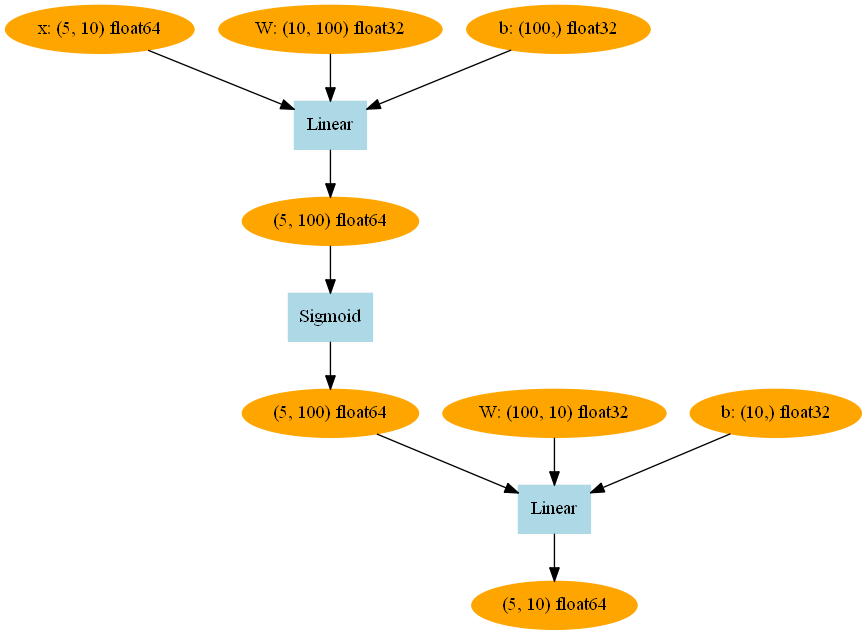

In [3]:
x = Variable(np.random.randn(5, 10), name='x')
model = TwoLayerNet(100, 10)
model.plot(x)

## Implement `2 layer neural network` with `TwoLayerNet` class

### 1. dataset

In [4]:
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

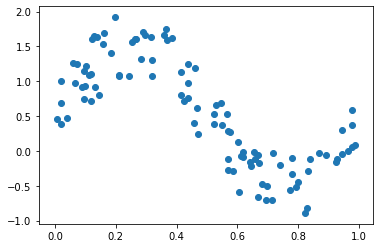

In [5]:
import matplotlib.pyplot as plt

plt.scatter(x, y);

### 2. Model

In [6]:
hidden_size = 10

model = TwoLayerNet(hidden_size, 1)

### 3. Train

You can see the `Parameter` administration is held by `Layer`!

In [7]:
lr = 0.2
iters = 10000

for i in range(iters):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)
    
    model.cleargrads()
    loss.backward()
    
    for p in model.params():
        p.data -= lr * p.grad.data
            
    if i % 1000 == 0:
        print(loss)

Variable(0.8165178492839196)
Variable(0.24990280802148895)
Variable(0.24609876581126014)
Variable(0.23721590814318072)
Variable(0.20793216413350174)
Variable(0.12311905720649353)
Variable(0.07888166506355153)
Variable(0.07655073683421634)
Variable(0.07637803086238225)
Variable(0.07618764131185568)


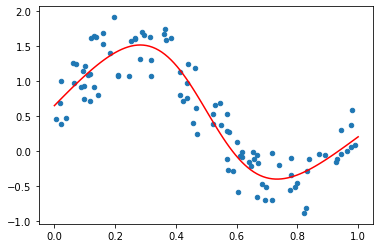

In [8]:
x_test = np.linspace(0, 1, 100).reshape(100, 1)
y_test = model(x_test)
plt.scatter(x, y, s=20)
plt.plot(x_test.data, y_test.data, color='red');

### Now we are free from managing `parameters` XD!
### We can manage everything in one `Layer` Class :)

## Implement `Multi Layer Perceptron (MLP)` with `Model` class

In [9]:
class MLP(Model):
    def __init__(self, fc_output_sizes, activation=F.sigmoid):
        super().__init__()
        self.activation = activation
        self.layers = []
        
        for i, out_size in enumerate(fc_output_sizes):
            layer = L.Linear(out_size)
            setattr(self, 'l' + str(i), layer)
            self.layers.append(layer)
            
    def forward(self, x):
        for l in self.layers[:-1]:
            x = self.activation(l(x))
        return self.layers[-1](x)

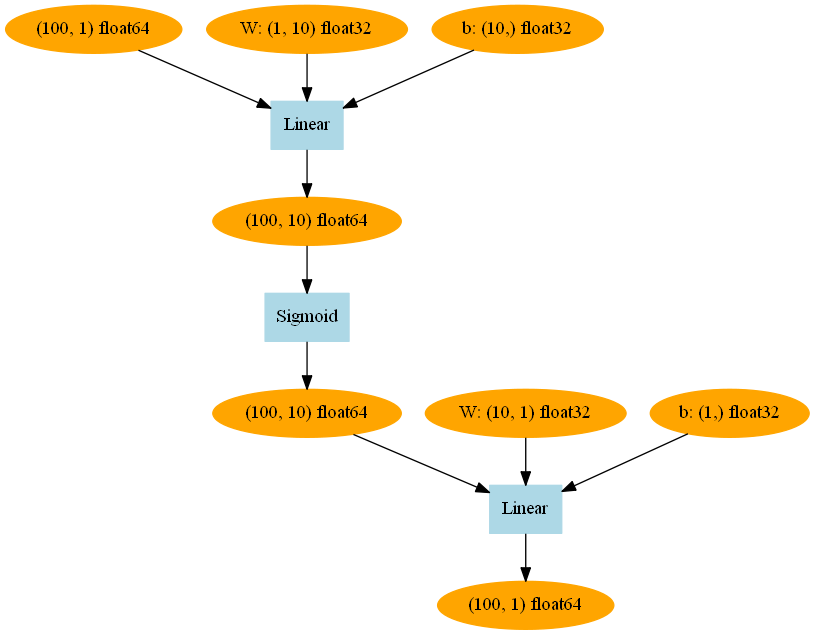

In [11]:
model = MLP((10, 1))
model.plot(x)

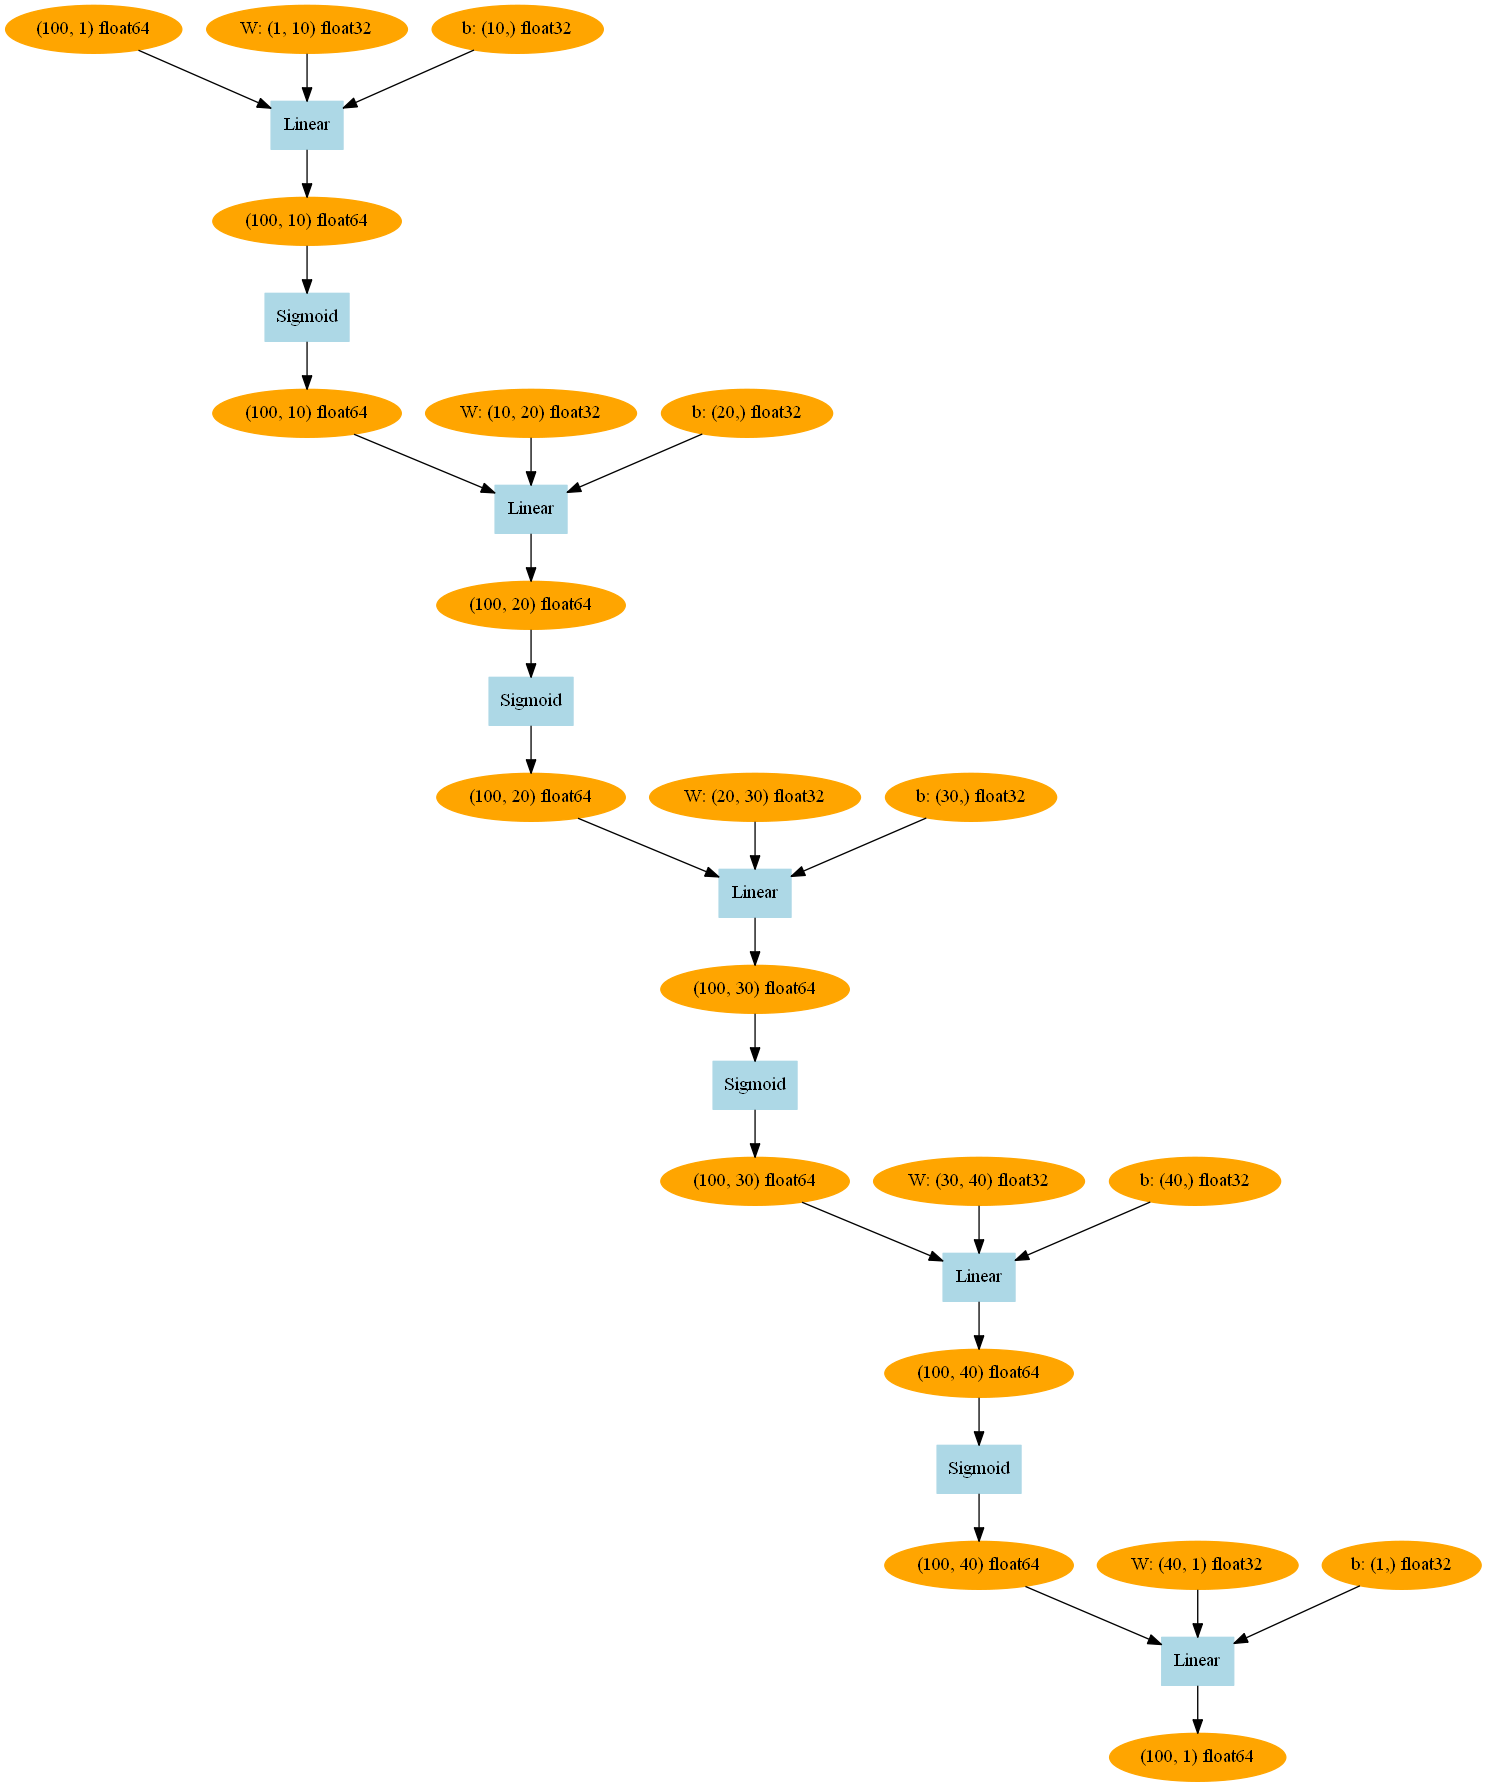

In [12]:
model = MLP((10, 20, 30, 40, 1))
model.plot(x)